# Hands‑On Autoencoders in PyTorch

In this notebook you will:

1. Load the MNIST dataset
2. Build a simple fully‑connected autoencoder
3. Train it to reconstruct images
4. Visualize reconstructions and the latent space
5. Extend it to a **denoising autoencoder**

You can run this notebook locally or in Google Colab.

## 0. Environment setup

If you're running in Colab, uncomment the cell below to install dependencies.

In [ ]:
# If you're in Colab, uncomment this:
# !pip install torch torchvision matplotlib


## 1. Imports and configuration

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. Data: MNIST digits

We use MNIST (28×28 grayscale images of handwritten digits).

In [2]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale from [0,1] to [-1,1] (helps training with tanh or similar activations)
    transforms.Lambda(lambda x: x * 2.0 - 1.0)
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)

100.0%
100.0%
100.0%
100.0%


(60000, 10000)

## 3. Model: Simple fully‑connected autoencoder

We flatten each 28×28 image into a 784‑dimensional vector, pass it through an encoder to a low‑dimensional latent space, then reconstruct it with a decoder.

In [3]:
latent_dim = 2  # keep it small so we can visualise later

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Tanh()  # outputs in [-1,1]
        )

    def encode(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

model = Autoencoder(latent_dim=latent_dim).to(device)
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

## 4. Training loop

We'll minimise mean squared error (MSE) between input and reconstruction.

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            x_hat = model(x)
            loss = criterion(x_hat, x)
            running_loss += loss.item() * x.size(0)
    return running_loss / len(dataloader.dataset)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

Epoch 01 | train loss: 0.2235 | val loss: 0.1878
Epoch 02 | train loss: 0.1813 | val loss: 0.1755
Epoch 03 | train loss: 0.1720 | val loss: 0.1691
Epoch 04 | train loss: 0.1667 | val loss: 0.1646
Epoch 05 | train loss: 0.1633 | val loss: 0.1616
Epoch 06 | train loss: 0.1605 | val loss: 0.1587
Epoch 07 | train loss: 0.1589 | val loss: 0.1581
Epoch 08 | train loss: 0.1574 | val loss: 0.1567
Epoch 09 | train loss: 0.1558 | val loss: 0.1563
Epoch 10 | train loss: 0.1546 | val loss: 0.1546


### 4.1. Plot training & validation loss

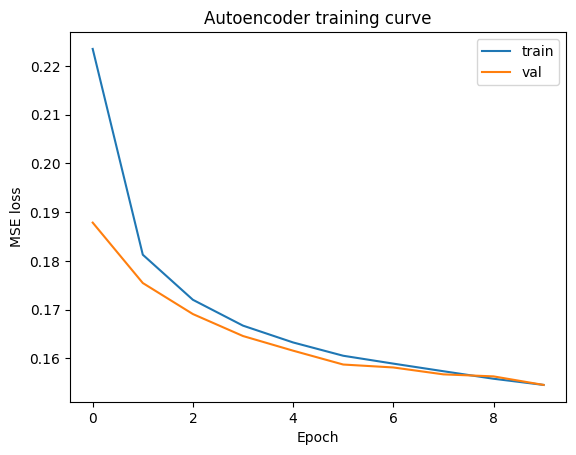

In [5]:
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Autoencoder training curve")
plt.show()

## 5. Visualising reconstructions

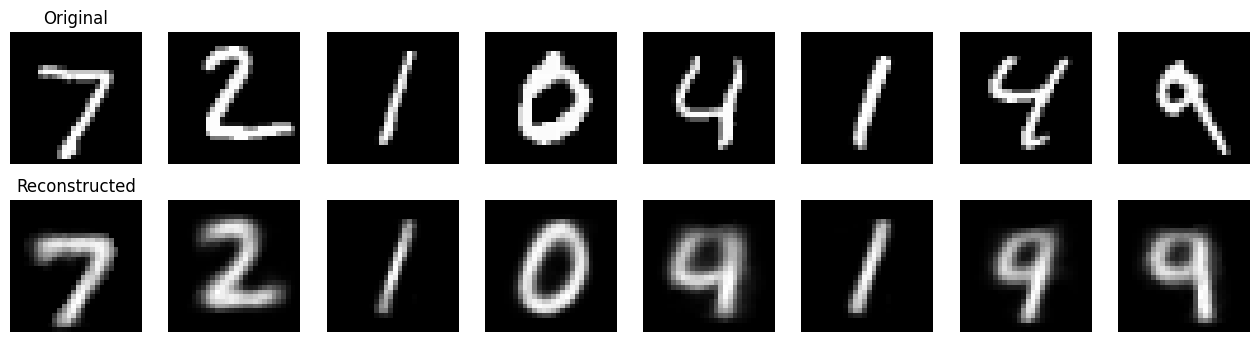

In [6]:
def show_reconstructions(model, dataloader, device, n=8):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x.to(device)
    with torch.no_grad():
        x_hat = model(x)
    x = x.cpu().numpy()
    x_hat = x_hat.cpu().numpy()

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # original
        plt.subplot(2, n, i+1)
        plt.imshow((x[i,0] + 1)/2, cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")
        # reconstruction
        plt.subplot(2, n, n + i + 1)
        plt.imshow((x_hat[i,0] + 1)/2, cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstructed")
    plt.show()

show_reconstructions(model, test_loader, device, n=8)

## 6. Latent space visualisation

Because `latent_dim=2`, we can directly scatter‑plot the 2D embedding coloured by digit label.

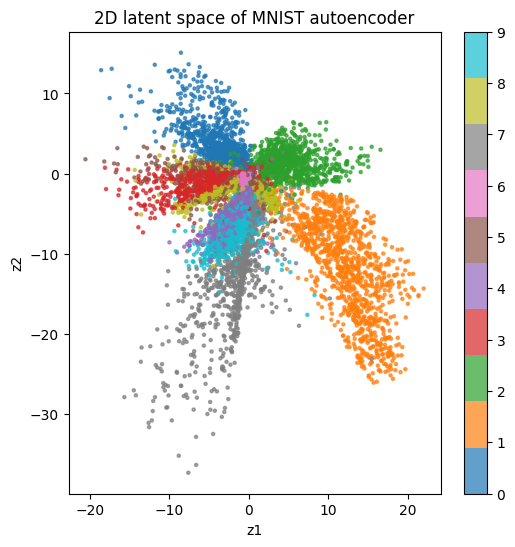

In [7]:
model.eval()
zs = []
ys = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = model.encode(x)
        zs.append(z.cpu().numpy())
        ys.append(y.numpy())

zs = np.concatenate(zs, axis=0)
ys = np.concatenate(ys, axis=0)

plt.figure(figsize=(6,6))
scatter = plt.scatter(zs[:,0], zs[:,1], c=ys, s=5, alpha=0.7, cmap="tab10")
plt.colorbar(scatter, ticks=range(10))
plt.title("2D latent space of MNIST autoencoder")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

## 7. Denoising autoencoder extension

A **denoising autoencoder** is trained to reconstruct the *clean* input from a *noisy* version of it. This forces the model to learn more robust features.

We'll reuse the same architecture, but add noise to the inputs during training.

In [8]:
def add_noise(x, noise_factor=0.5):
    noise = noise_factor * torch.randn_like(x)
    x_noisy = x + noise
    return torch.clamp(x_noisy, -1.0, 1.0)

denoising_model = Autoencoder(latent_dim=latent_dim).to(device)
optimizer_denoise = torch.optim.Adam(denoising_model.parameters(), lr=1e-3)

def train_denoising_epoch(model, dataloader, optimizer, criterion, device, noise_factor=0.5):
    model.train()
    running_loss = 0.0
    for x, _ in dataloader:
        x = x.to(device)
        x_noisy = add_noise(x, noise_factor).to(device)

        optimizer.zero_grad()
        x_hat = model(x_noisy)
        loss = criterion(x_hat, x)  # target is clean x
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(dataloader.dataset)

num_epochs_denoise = 5
for epoch in range(1, num_epochs_denoise+1):
    loss = train_denoising_epoch(denoising_model, train_loader, optimizer_denoise, criterion, device)
    print(f"[Denoising] Epoch {epoch:02d} | train loss: {loss:.4f}")

[Denoising] Epoch 01 | train loss: 0.2290
[Denoising] Epoch 02 | train loss: 0.1841
[Denoising] Epoch 03 | train loss: 0.1745
[Denoising] Epoch 04 | train loss: 0.1692
[Denoising] Epoch 05 | train loss: 0.1660


### 7.1. Compare noisy vs denoised vs original

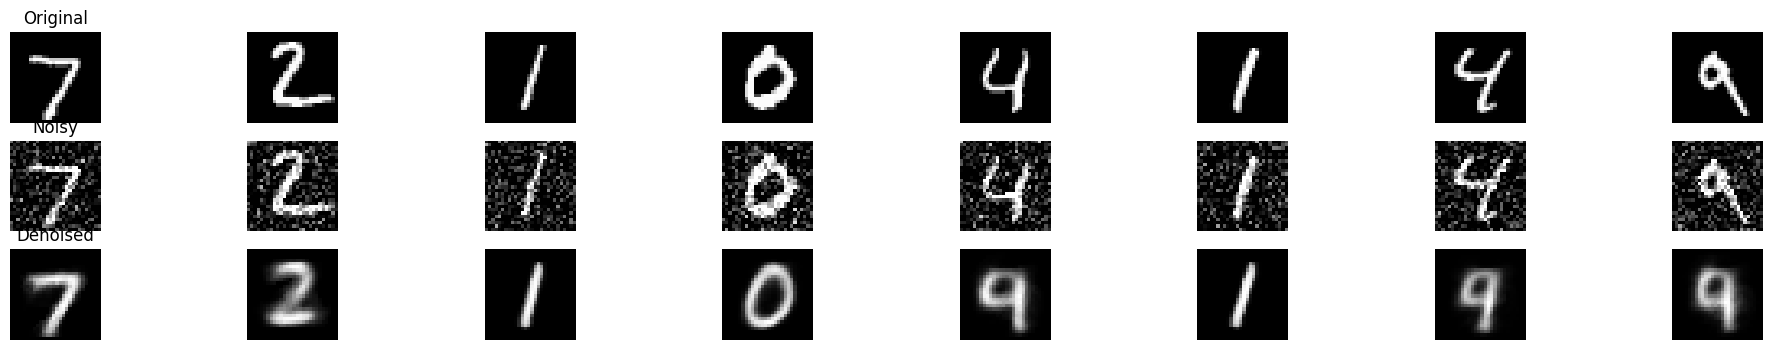

In [9]:
def show_denoising_examples(model, dataloader, device, n=8, noise_factor=0.5):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x.to(device)
    x_noisy = add_noise(x, noise_factor).to(device)
    with torch.no_grad():
        x_denoised = model(x_noisy)

    x = x.cpu().numpy()
    x_noisy = x_noisy.cpu().numpy()
    x_denoised = x_denoised.cpu().numpy()

    plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # original
        plt.subplot(3, n, i+1)
        plt.imshow((x[i,0] + 1)/2, cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")
        # noisy
        plt.subplot(3, n, n + i + 1)
        plt.imshow((x_noisy[i,0] + 1)/2, cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Noisy")
        # denoised
        plt.subplot(3, n, 2*n + i + 1)
        plt.imshow((x_denoised[i,0] + 1)/2, cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Denoised")
    plt.show()

show_denoising_examples(denoising_model, test_loader, device, n=8, noise_factor=0.5)

## 8. Where to go next

- Try different `latent_dim` values (e.g. 8, 16, 32) and see how reconstruction quality and latent space change.
- Replace the fully‑connected layers with convolutional layers for better image modelling.
- Add regularisation or sparsity penalties to the latent representation.
- Move towards **variational autoencoders (VAEs)** for generative modelling.